In [1]:
import cv2,os
data_path=r'C:\Users\keert\dataset'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]
label_dict=dict(zip(categories,labels))
print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
img_size=100
data=[]
target=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resized=cv2.resize(gray,(100,100))
            data.append(resized)
            target.append(label_dict[category])
            #print(label_dict[category])
        except Exception as e:
            print('Exception:',e)

In [3]:
import numpy as np
data=np.array(data)/255.0
#print(data)
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils
new_target=np_utils.to_categorical(target)

Using TensorFlow backend.


In [4]:
np.save('data',data)
np.save('target',new_target)

In [5]:
import numpy as np
data=np.load('data.npy')
target=np.load('target.npy')

In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [7]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=20,callbacks=[checkpoint],validation_split=0.2)

Train on 2759 samples, validate on 690 samples
Epoch 1/20
2759/2759 [==============================] - 211s 77ms/step - loss: 0.6186 - accuracy: 0.6607 - val_loss: 0.5372 - val_accuracy: 0.7232
Epoch 2/20
2759/2759 [==============================] - 186s 67ms/step - loss: 0.4858 - accuracy: 0.7648 - val_loss: 0.6643 - val_accuracy: 0.6391
Epoch 3/20
2759/2759 [==============================] - 196s 71ms/step - loss: 0.4204 - accuracy: 0.8046 - val_loss: 0.3575 - val_accuracy: 0.8391
Epoch 4/20
2759/2759 [==============================] - 172s 62ms/step - loss: 0.3544 - accuracy: 0.8398 - val_loss: 0.3321 - val_accuracy: 0.8522
Epoch 5/20
2759/2759 [==============================] - 183s 66ms/step - loss: 0.2728 - accuracy: 0.8742 - val_loss: 0.3000 - val_accuracy: 0.8638
Epoch 6/20
2759/2759 [==============================] - 159s 58ms/step - loss: 0.2101 - accuracy: 0.9130 - val_loss: 0.2813 - val_accuracy: 0.8855
Epoch 7/20
2759/2759 [==============================] - 191s 69ms/step 

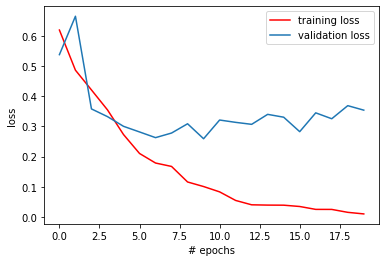

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

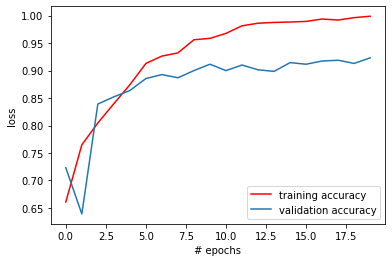

In [10]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
print(model.evaluate(test_data,test_target))

384/384 [==============================] - 7s 17ms/step
[0.34784794722994167, 0.9140625]


In [12]:
import cv2
face_clsfr=cv2.CascadeClassifier(r'C:\Users\keert\frontalFace10\haarcascade_frontalface_default.xml')
source=cv2.VideoCapture(0)
labels_dict={0:'MASK',1:'NO MASK'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [ ]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()